In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, KFold, cross_val_predict

### Loading data files

In [35]:
DPQ = '/Users/frank/Desktop/UCB/IEOR/INDENG242/project/DPQ_J.XPT'
SLQ = '/Users/frank/Desktop/UCB/IEOR/INDENG242/project/SLQ_J.XPT'

In [36]:
dpq_path = DPQ
slq_path = SLQ

dpq_data = pd.read_sas(dpq_path, format="xport")
slq_data = pd.read_sas(slq_path, format="xport")

dpq_data.shape, slq_data.shape


((5533, 11), (6161, 11))

# SLQ & DPQ dataset

### Data Cleaning

In [37]:
merged_df = pd.merge(dpq_data, slq_data, on='SEQN', how='inner')

# For the abnormal min number, I replace it with nan value instead
merged_df.loc[:, 'DPQ020'] = merged_df['DPQ020'].replace(5.397605e-79, np.nan)
cleaned_merged = merged_df.dropna(subset=['DPQ020']).copy()

# Create 'result' column: 1 means depressed (DPQ020 in [1, 2, 3]), 0 otherwise
cleaned_merged.loc[:, 'result'] = cleaned_merged['DPQ020'].apply(lambda x: 1 if x in [1, 2, 3] else 0)

In [38]:
# Convert the time specific column in minutes unit for better reading
for col in ['SLQ300', 'SLQ310', 'SLQ320', 'SLQ330']:
    if col in cleaned_merged.columns:
        cleaned_merged.loc[:, col] = cleaned_merged[col].str.decode('utf-8').str.extract(r'(\d+):(\d+)').apply(
            lambda x: int(x[0]) * 60 + int(x[1]) if not pd.isnull(x[0]) else np.nan, axis=1
        )

# Impute missing values for all column in merged dataset
for col in cleaned_merged.columns:
    if cleaned_merged[col].dtype in ['float64', 'int64']:
        cleaned_merged.loc[:, col].fillna(cleaned_merged[col].median(), inplace=True)
    else:
        cleaned_merged.loc[:, col].fillna(cleaned_merged[col].mode()[0], inplace=True)

/var/folders/0t/zk8zgmj95b5dfs07q695tcm40000gn/T/ipykernel_3521/1026009831.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_merged.loc[:, col].fillna(cleaned_merged[col].median(), inplace=True)
/var/folders/0t/zk8zgmj95b5dfs07q695tcm40000gn/T/ipykernel_3521/1026009831.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

In [39]:
# Oversample the minority class
major = cleaned_merged[cleaned_merged['result'] == 0]
minor = cleaned_merged[cleaned_merged['result'] == 1]

if len(major) > 0 and len(minor) > 0:
    minority_class_oversampled = resample(
        minor,
        replace=True,
        n_samples=len(major),
        random_state=42
    )
    balanced_data = pd.concat([major, minority_class_oversampled])
else:
    raise ValueError("One of the classes is empty. Cannot perform resampling.")

In [40]:
# Specify the independent and dependent variable
X = balanced_data.drop(columns=['SEQN', 'DPQ020', 'result'])
y = balanced_data['result']

# 3:7 data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5419, 19), (2323, 19), (5419,), (2323,))

In [42]:
def metrics_helper(y_test, y_pred, y_prob):
    TP = np.sum((y_test == 1) & (y_pred == 1))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    TN = np.sum((y_test == 0) & (y_pred == 0))
    FN = np.sum((y_test == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)
    auc_score = roc_auc_score(y_test, y_prob)

    return accuracy, tpr, fpr, auc_score


In [43]:
# Logistic regression
results = {}
logreg = sm.Logit(y_train, X_train).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.446527
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 result   No. Observations:                 5419
Model:                          Logit   Df Residuals:                     5400
Method:                           MLE   Df Model:                           18
Date:                Wed, 18 Dec 2024   Pseudo R-squ.:                  0.3558
Time:                        18:09:17   Log-Likelihood:                -2419.7
converged:                       True   LL-Null:                       -3756.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DPQ010         0.7290      0.055     13.227      0.000       0.621       0.837
DPQ030         0.0294      0.

In [44]:
y_prob_logreg = logreg.predict(X_test)
y_pred_logreg = pd.Series([1 if X > 1/2 else 0 for X in y_prob_logreg], index=y_prob_logreg.index)
results['Logistic Regression'] = metrics_helper(y_test, y_pred_logreg, y_prob_logreg)

In [45]:
# LDA
lda_model = LDA()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)
y_prob_lda = lda_model.predict_proba(X_test)[:, 1]
results['LDA'] = metrics_helper(y_test, y_pred_lda, y_prob_lda)


In [46]:
# random forest
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier(random_state=42)

y_prob_rf_cv = cross_val_predict(rf, X_train, y_train, cv=kf, method='predict_proba')[:, 1]
y_pred_rf_cv = cross_val_predict(rf, X_train, y_train, cv=kf)

rf.fit(X_train, y_train)  
y_pred_test_rf = rf.predict(X_test)  
y_prob_test_rf = rf.predict_proba(X_test)[:, 1]

results['Random Forest CV'] = metrics_helper(y_train, y_pred_rf_cv, y_prob_rf_cv)
results['Random Forest'] = metrics_helper(y_test, y_pred_test_rf, y_prob_test_rf)

5419

In [47]:
# xgboost
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

y_prob_xgb_cv = cross_val_predict(xgb_model, X_train, y_train, cv=kf, method='predict_proba')[:, 1]
y_pred_xgb_cv = cross_val_predict(xgb_model, X_train, y_train, cv=kf)


xgb_model.fit(X_train, y_train)
y_pred_test_xgb = xgb_model.predict(X_test) 
y_prob_test_xgb = xgb_model.predict_proba(X_test)[:, 1] 


results['XGBoost CV'] = metrics_helper(y_train, y_pred_xgb_cv, y_prob_xgb_cv)
results['XGBoost'] = metrics_helper(y_test, y_pred_test_xgb, y_prob_test_xgb)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:09:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:09:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:09:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:09:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

In [48]:
# svm
svm_model = SVC(probability=True, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

y_prob_svm_cv = cross_val_predict(svm_model, X_train, y_train, cv=kf, method='predict_proba')[:, 1]
y_pred_svm_cv = cross_val_predict(svm_model, X_train, y_train, cv=kf)

svm_model.fit(X_train, y_train)  
y_pred_test_svm = svm_model.predict(X_test)  
y_prob_test_svm = svm_model.predict_proba(X_test)[:, 1] 

results['SVM CV'] = metrics_helper(y_train, y_pred_svm_cv, y_prob_svm_cv)
results['SVM'] = metrics_helper(y_test, y_pred_test_svm, y_prob_test_svm)

In [49]:
# Print summary table
summary_table = pd.DataFrame(results, index=['Accuracy', 'TPR', 'FPR', 'AUC']).T
print(summary_table)

                     Accuracy       TPR       FPR       AUC
Logistic Regression  0.819199  0.772251  0.135089  0.892690
LDA                  0.805854  0.727749  0.118097  0.883353
Random Forest CV     0.909762  0.951927  0.132888  0.974455
Random Forest        0.930693  0.961606  0.099405  0.986507
XGBoost CV           0.890386  0.917798  0.137342  0.945223
XGBoost              0.908308  0.933682  0.116398  0.964021
SVM CV               0.546964  0.336514  0.240163  0.567764
SVM                  0.548429  0.350785  0.259133  0.586994


### Visualization

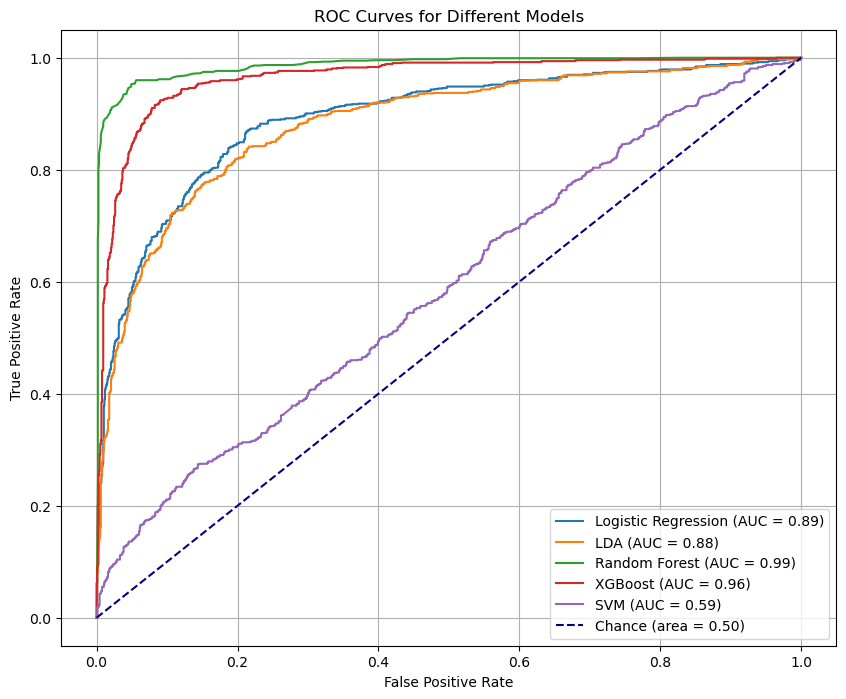

In [50]:

# Plot AUC curves
plt.figure(figsize=(10, 8))

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_logreg)
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {results['Logistic Regression'][3]:.2f})")

fpr_lda, tpr_lda, _ = roc_curve(y_test, y_prob_lda)
plt.plot(fpr_lda, tpr_lda, label=f"LDA (AUC = {results['LDA'][3]:.2f})")

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_test_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {results['Random Forest'][3]:.2f})")

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_test_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {results['XGBoost'][3]:.2f})")

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_test_svm)
plt.plot(fpr_svm, tpr_svm, label=f"SVM (AUC = {results['SVM'][3]:.2f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Chance (area = 0.50)')
plt.title('ROC Curves for Different Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [51]:
compare_data = cleaned_merged.groupby('result')[['SLD012', 'SLD013']].mean()
compare_data.columns = ['Avg Sleep Hours Weekdays', 'Avg Sleep Hours Weekends']
compare_data


,Avg Sleep Hours Weekdays,Avg Sleep Hours Weekends
result,,
0,7.575562,8.278481
1,7.642390,8.250409


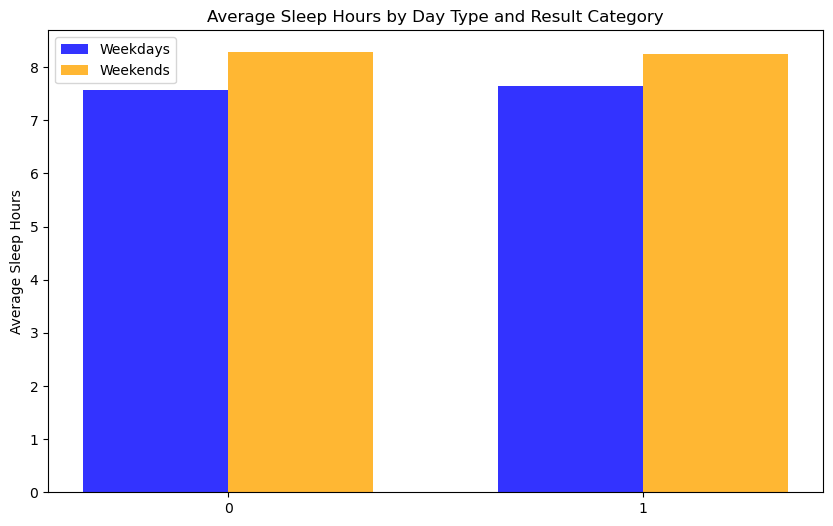

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))

positions = list(range(len(compare_data['Avg Sleep Hours Weekdays'])))
width = 0.35

plt.bar([p - width/2 for p in positions], compare_data['Avg Sleep Hours Weekdays'], width, alpha=0.8, color='blue', label='Weekdays')
plt.bar([p + width/2 for p in positions], compare_data['Avg Sleep Hours Weekends'], width, alpha=0.8, color='orange', label='Weekends')

ax.set_ylabel('Average Sleep Hours')
ax.set_title('Average Sleep Hours by Day Type and Result Category')
plt.xticks(positions, [str(x) for x in compare_data.index])
ax.legend(['Weekdays', 'Weekends'], loc='upper left')
plt.show()


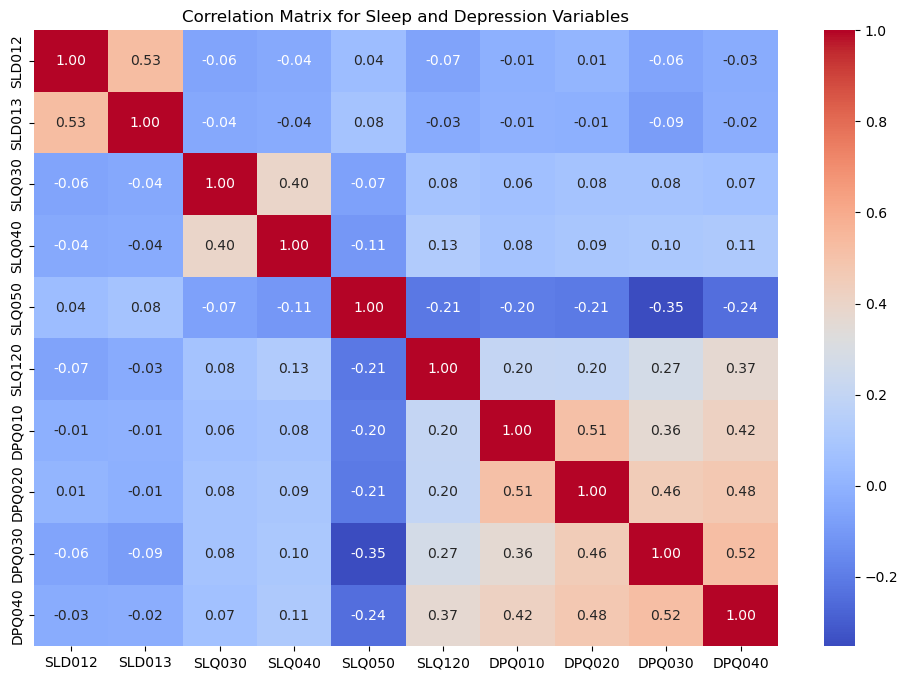

In [53]:
correlation_matrix = cleaned_merged[['SLD012', 'SLD013', 'SLQ030', 'SLQ040', 'SLQ050', 'SLQ120',
                                   'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040']].corr()

# Heatmap for correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix for Sleep and Depression Variables')
plt.show()

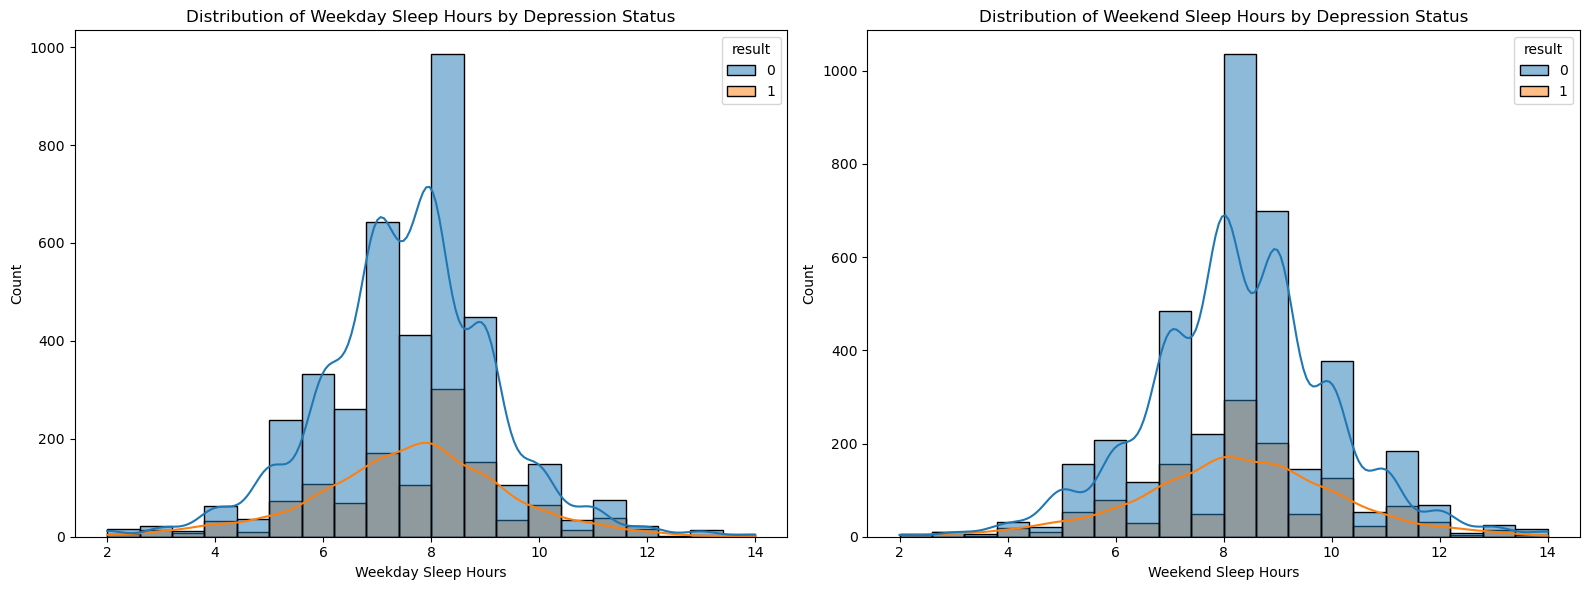

In [54]:
# Histograms for sleep patterns by depression 
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(data=cleaned_merged, x='SLD012', hue='result', kde=True, ax=axes[0], bins=20)
axes[0].set_title('Distribution of Weekday Sleep Hours by Depression Status')
axes[0].set_xlabel('Weekday Sleep Hours')
axes[0].set_ylabel('Count')

sns.histplot(data=cleaned_merged, x='SLD013', hue='result', kde=True, ax=axes[1], bins=20)
axes[1].set_title('Distribution of Weekend Sleep Hours by Depression Status')
axes[1].set_xlabel('Weekend Sleep Hours')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()